# Bayesian Changepoint Detection in Python

This code computes the probability of changepoints in a time series.7 In this notebook I show how you can use it.

First let's generate some data:

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*10
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data

In [3]:
data = generate_normal_time_series(7, 50, 200)

Let's have a look, how they look like:

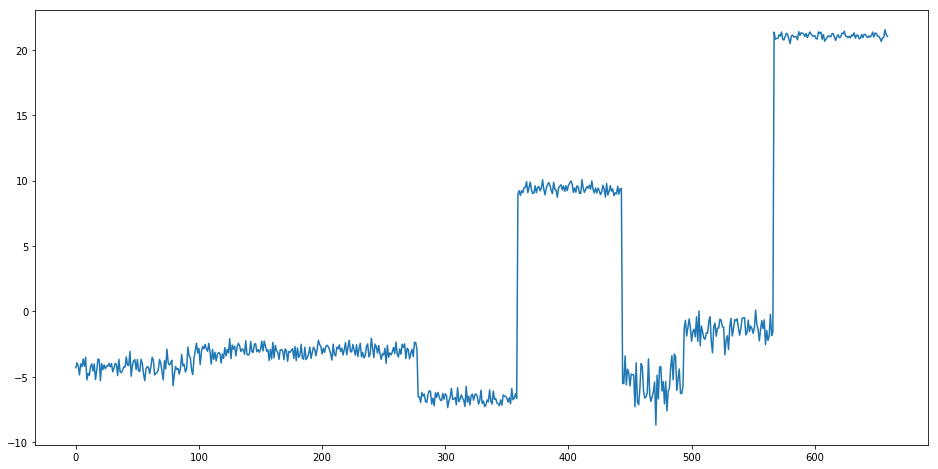

In [5]:
fig, ax = plt.subplots(figsize=[16, 8])
ax.plot(data)

## Offline Changepoint Detection

Lets compute the probability of changepoints at each time step. We need two things for that. First a prior of how probable is it to have two successive changepoints with the distance `t`. The second thing is a model of the likelihood of data in a sequence `[s, t]` of the data, given that in this sequence there is *no* changepoint.

For this example we assume a uniform prior over the length of sequences (`const_prior`) and a piecewise gaussian model (`gaussian_obs_log_likelihood`).

In [6]:
import cProfile

In [7]:
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial

Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

Use scipy logsumexp().


The `offline_changepoint_detection()` function returns three things: `Q[t]`, the log-likelihood of data `[t, n]`, `P[t, s]`, the log-likelihood of a datasequence `[t, s]`, given there is no changepoint between `t` and `s` and `Pcp[i, t]`, the log-likelihood that the `i`-th changepoint is at time step `t`. To actually get the probility of a changepoint at time step `t` sum the probabilities.

How does that look like for our toy-data?

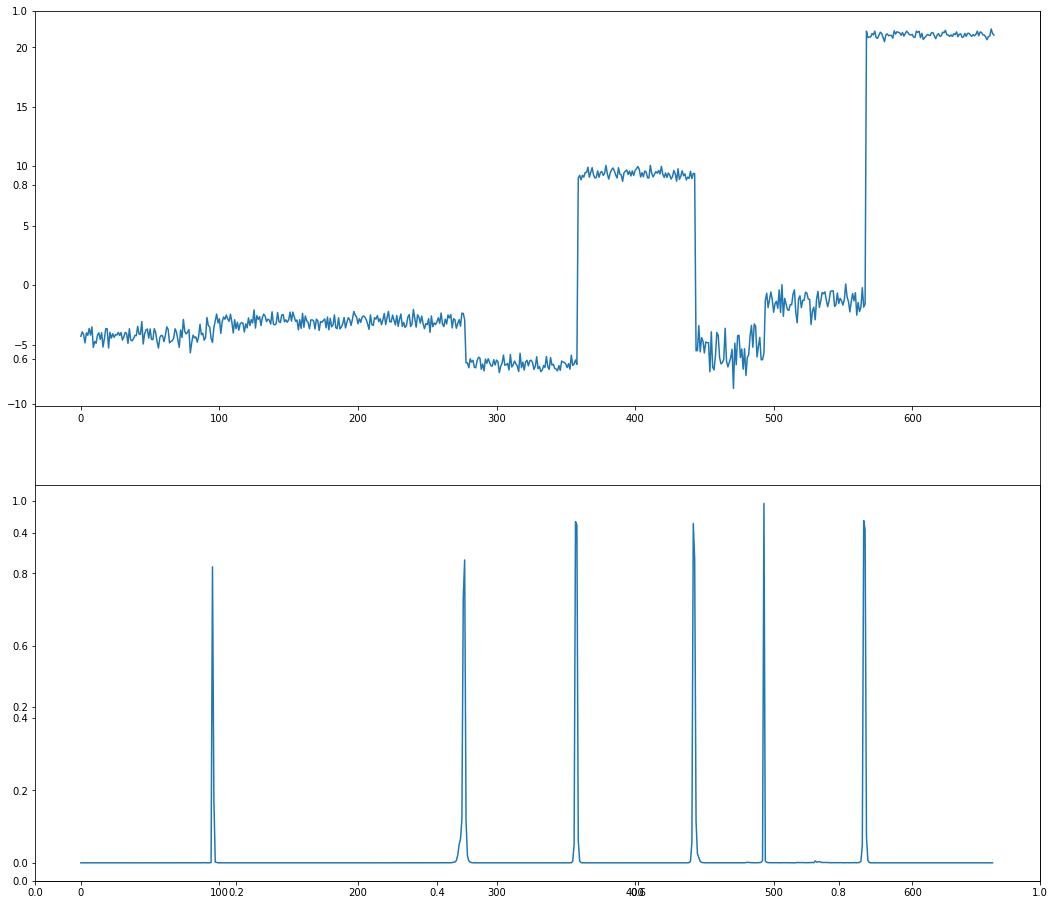

In [8]:
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))

That works pretty well, but is somewhat slow. It's possible to speed that up by truncating a sum in the algorithm. However that sometimes leeds to $\infty$ values. Set the `truncate` parameter to e.g. `-10` to test that out.

To understand, what is happening have a look at the following papers:

[1] Paul Fearnhead, Exact and Efficient Bayesian Inference for Multiple
Changepoint problems, Statistics and computing 16.2 (2006), pp. 203--213

[2] Xuan Xiang, Kevin Murphy, Modeling Changing Dependency Structure in
Multivariate Time Series, ICML (2007), pp. 1055--1062
                                                                                                                                                                                          

## Online Changepoint Detection

Let's assume the data points come in one after another and not as these nice batches. During the process you want to know if the new point has the same hyperparameter or different ones. You need an online changepoint detection.

Happily there is one, although it's interface is kind of suboptimal so far, in that it expects batches of data still and just assumes they drop in over time... I will change that at some point.

In [11]:
def plot_thp(trace_file, title, start=0, end=5800):
    time_s = []
    thp_mbps = []
    with open(trace_file, 'rb') as f:
        for line in f:
            parse = line.split()
            if len(parse) == 2:
                try:
                    time_s.append(float(parse[0]))
                    thp_mbps.append(float(parse[1]))
                except ValueError:
                    print('we got an error: ', parse[0], parse[1])
    time_s = np.array(time_s)
    thp_mbps = np.array(thp_mbps)
    
    fig = plt.figure(figsize=(20,10))
    plt.plot(time_s[start:end], thp_mbps[start:end])
    plt.xlabel('time')
    plt.ylabel('throughput (Mbps)')
    plt.title(title)
#     plt.tight_layout()
    plt.show()
    
    return thp_mbps[start:end]

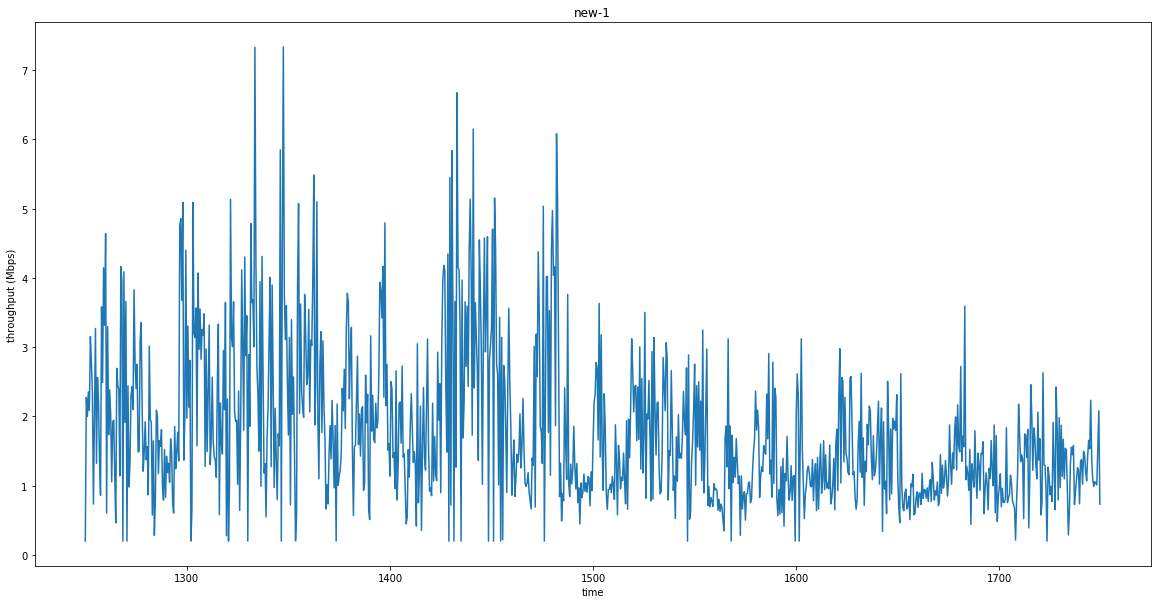

In [46]:
trace_file = '/Users/federerjiang/research-project/aitrans-competition/final/trace/new_network_trace/20'
thp_mbps = plot_thp(trace_file, 'new-1', 2500, 3500)

In [47]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
from functools import partial

data = thp_mbps
R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

The online version computes slightly different things. For each time step it returns the probability distribution over the length of the last sequence. E.g. `R[7, 3]` is the probability at time step `7` that the last sequence is already `3` time steps long. It also returns the MAP estimate at each timestep for convenience.

To plot the distributions we use a grey-scale colormap, black is zero, white 1. We also plot the probability at each time step for a sequence length of 0, i.e. the probability of the current time step to be a changepoint.

Because it's very hard to correctly evaluate a change after a single sample of a new distribution, we instead can "wait" for `Nw` samples and evalute the probability of a change happening `Nw` samples prior.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


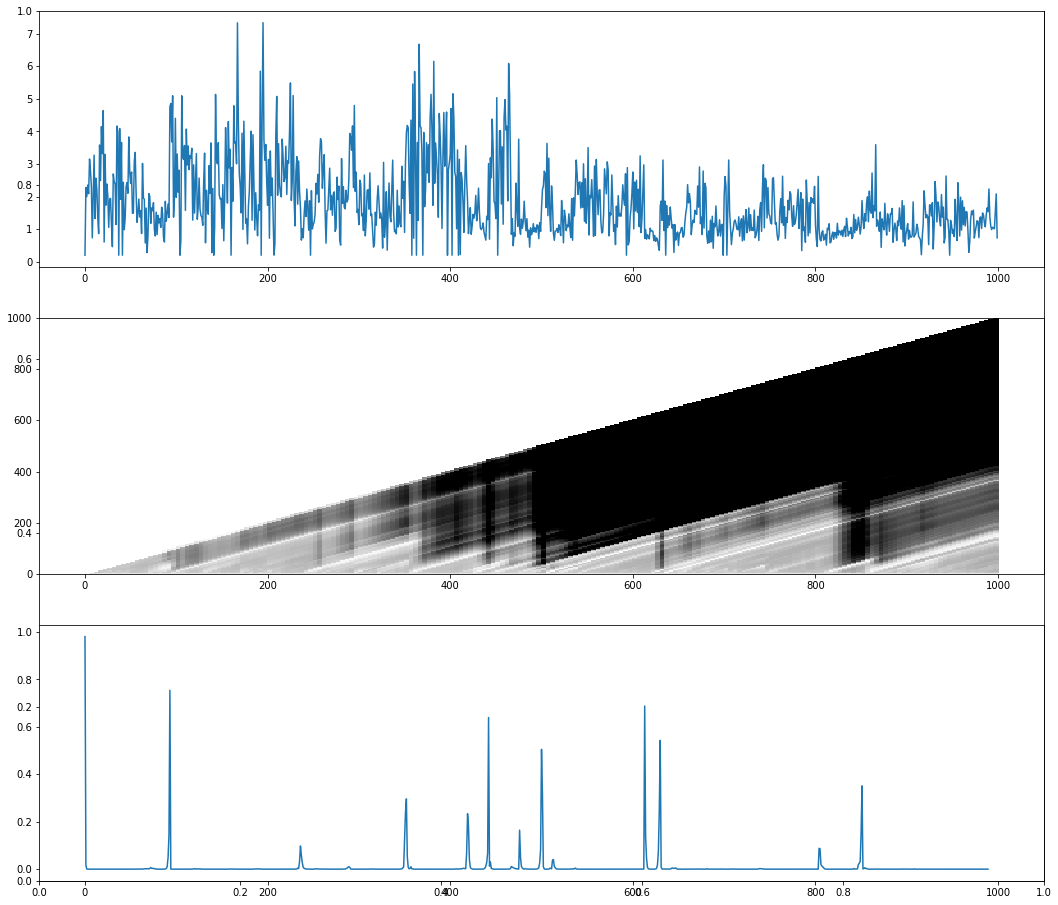

In [48]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[18, 16])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

Well, not bad, considering how much faster it is (if you can afford waiting for that extra `Nw` samples). To understand the whole algorithm look at

[1] Ryan P. Adams, David J.C. MacKay, Bayesian Online Changepoint Detection,
arXiv 0710.3742 (2007)

There you also find a Matlab version, which this code is based on.

In [ ]:
data = generate_normal_time_series(7, 50, 200)

In [ ]:
%timeit Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood)

In [ ]:
%timeit R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(10, .03, 1, 0))